In [2]:
import torch
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.trainer import TACTISTrainer
from tactis.gluon.dataset import generate_hp_search_datasets, generate_prebacktesting_datasets, generate_backtesting_datasets
from tactis.gluon.metrics import compute_validation_metrics
from tactis.gluon.plots import plot_four_forecasts
from gluonts.evaluation.backtest import make_evaluation_predictions

import pandas as pd
import numpy as np

from gluonts.dataset.common import ListDataset, MetaData
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
import warnings
import random

from tqdm import tqdm
import matplotlib.pyplot as plt

In [60]:
#################################################prognozes iki 2024K4
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="gluonts")

#"extended_data2.csv" - pirmas kintamųjų rinkinis, "extended_data3.csv" stacionarus kint.rink., "extended_data4.csv" nestacionarus kint. rink
#file_location = "extended_data2.csv"
#file_location = "extended_data3.csv"
file_location = "extended_data4.csv"
df = (
    pd.read_csv(file_location)
      .assign(timestamp=lambda d: pd.to_datetime(d["timestamp"]))
      .set_index("timestamp")
      .sort_index()
)

FREQ = "QS-MAR"
PRED_LEN = 12
history_factor=5
history_length = history_factor * PRED_LEN


series = [
    {
        FieldName.START : pd.Timestamp(df.index[0], freq=FREQ),
        FieldName.TARGET: df[col].to_numpy(dtype=np.float32),
        FieldName.ITEM_ID: col,
    }
    for col in df.columns
]

# 80/20 split:

train_entries, valid_entries = [], []

for entry in series:                      # one loop per original column
    target      = entry[FieldName.TARGET]
    n_total     = len(target)

    cut_point   = int(0.8 * n_total)      # ---- 80 % cutoff
    cut_point   = max(cut_point, history_length + 1)  # safety guard

    # ------------------ training slice (0 ... cut_point-1)
    e_train = entry.copy()
    e_train[FieldName.TARGET] = target[:cut_point]
    train_entries.append(e_train)

    start_idx   = cut_point - history_length
    e_valid = entry.copy()
    e_valid[FieldName.START] = (
        entry[FieldName.START]
        + pd.tseries.frequencies.to_offset(FREQ) * start_idx
    )
    e_valid[FieldName.TARGET] = target[start_idx:]
    valid_entries.append(e_valid)


train_ds = MultivariateGrouper()(train_entries)
valid_ds = MultivariateGrouper()(valid_entries)
metadata = MetaData(freq=FREQ, prediction_length=PRED_LEN)

# Tactis call:

estimator = TACTiSEstimator(
    model_parameters = {
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 6,
        "copula_input_encoder_layers": 6,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 4,
        "positional_encoding":{
            "dropout": 0.1,
        },
        "flow_temporal_encoder":{
            "attention_layers": 6,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.1,
        },
        "copula_temporal_encoder":{
            "attention_layers": 6,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.1,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    },
    num_series = train_ds.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = TACTISTrainer(
        epochs_phase_1 = 20,
        epochs_phase_2 = 20,
        batch_size = 32,
        #num_batches_per_epoch = 512,
        learning_rate = 0.001,
        weight_decay = 1e-4,
        #maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda:0"),
        checkpoint_dir = "checkpoints",
    ),
    cdf_normalization = False,
    num_parallel_samples = 300,
)

model = estimator.train(train_ds, valid_ds, num_workers=1)

/tmp/slurm-aran9182-176663/ipykernel_172111/3876360101.py:30: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  FieldName.START : pd.Timestamp(df.index[0], freq=FREQ),


Checkpoints will be saved at checkpoints
Performing a batch size search with 10 iterations.
Initial batch size: 32
Using a batch size of: 32
Start epoch: 0
Total Epochs: 40
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 40
Training.
Total number of training batches: 50
Epoch: 0 Average training loss: 627290.8940051958
Validation.
Total number of validation batches: 1
Epoch: 0 Average validation loss: 26.997573852539062
Epochs since best epoch: 0
Checkpoint of epoch 0 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 0 saved at checkpoints/best_stage_1.pth.tar


Epoch: 1 / 40
Training.
Total number of training batches: 50
Epoch: 1 Average training loss: 19239.320205987668
Validation.
Total number of validation batches: 1
Epoch: 1 Average validation loss: 33.826873779296875
Epochs since best epoch: 1
Checkpoint of epoch 1 saved at checkpoints/last_stage_1.pth.tar


Epoch: 2 / 40
Training.
Total number of training batches: 50
Epoch: 2 Average training loss: 29620.498

In [61]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since a 
# TACTiSPredictionNetwork is created for inference from the `model_parameters`
estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = estimator.create_transformation()
device = estimator.trainer.device
predictor = estimator.create_predictor(
    transformation=transformation,
    trained_network=model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_length,
)

In [62]:
predictor.batch_size = 32
metrics, ts_wise_metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=valid_ds,
    window_length=estimator.history_length + estimator.prediction_length,
    prediction_length=estimator.prediction_length,
    num_samples=300,
    split=False,
)

Using batch size: 32


In [5]:
metrics

{'CRPS': 0.2090352655037888,
 'ND': 0.26149105322556004,
 'NRMSE': 0.3685851275877596,
 'MSE': 0.03399077243617689,
 'CRPS-Sum': 0.05374765487498529,
 'ND-Sum': 0.0577105244036824,
 'NRMSE-Sum': 0.06594066115063611,
 'MSE-Sum': 610.3020426432291,
 'num_nan': 0,
 'num_inf': 0}

In [63]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_ds, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)


Saved all forecasts to forecast_outputs/all_forecasts.csv
Saved all forecasts to forecast_outputs/all_forecasts.csv


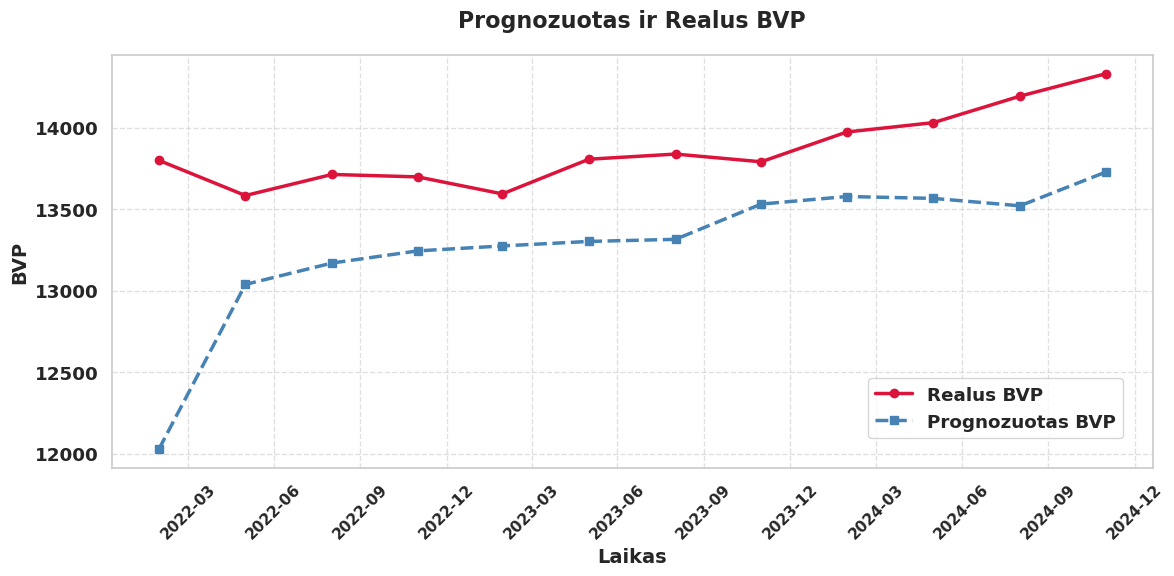

RMSE:
2022-03-01    1773.383789
2022-06-01     545.558594
2022-09-01     543.731055
2022-12-01     454.320312
2023-03-01     319.356445
2023-06-01     504.602148
2023-09-01     523.303320
2023-12-01     259.547266
2024-03-01     395.849805
2024-06-01     464.786328
2024-09-01     672.928320
2024-12-01     603.811133
Freq: QS-MAR, dtype: float64


In [64]:
from pathlib import Path
from gluonts.dataset.field_names import FieldName
from sklearn.metrics import mean_squared_error

#parametrai
pred_len = forecasts[0].prediction_length  # 12
num_series = forecasts[0].mean.shape[1]    # 63 (eil kiekis)
freq = forecasts[0].freq                 


timestamps = pd.date_range(
    start=forecasts[0].start_date,
    periods=pred_len,
    freq=freq
)

# pavadinimai eiluciu
series_names = [entry[FieldName.ITEM_ID] for entry in valid_entries]

#DataFrame: eil - timestamp, stulp - pavadinimai
#forecasts[0].mean.shape == (pred_len, num_series)
mean_array = forecasts[0].mean  # (12, 63)

forecast_df = pd.DataFrame(mean_array, columns=series_names, index=timestamps)


#CSV
output_folder = Path("forecast_outputs")
output_folder.mkdir(exist_ok=True)
forecast_df.to_csv(output_folder / "all_forecasts.csv")
print(f"Saved all forecasts to {output_folder / 'all_forecasts.csv'}")

#BVP
series_name = "BVP"
series_names = [entry[FieldName.ITEM_ID] for entry in series]
idx = series_names.index(series_name)

#prognoze
forecast = forecasts[0]  # tikimybine prognoze
pred_len = forecast.prediction_length
num_series = forecast.mean.shape[1]
freq = forecast.freq
timestamps = pd.date_range(
    start=forecast.start_date,
    periods=pred_len,
    freq=freq
)
mean_array = forecast.mean  # (12, 63)

#df su prognoozem
forecast_df = pd.DataFrame(mean_array, columns=series_names, index=timestamps)
output_folder = Path("forecast_outputs")
output_folder.mkdir(exist_ok=True)
forecast_df.to_csv(output_folder / "all_forecasts.csv")
print(f"Saved all forecasts to {output_folder / 'all_forecasts.csv'}")

# prognoze+reali
forecast_bvp = mean_array[:, idx]
actual_series = df[series_name]   
actual_bvp = actual_series[-PRED_LEN:] 
actual_bvp.index = timestamps
assert len(actual_bvp) == pred_len
assert len(forecast_bvp) == pred_len

# RMSE
rmse = np.sqrt(mean_squared_error(actual_bvp.values, forecast_bvp))
rmse_series = pd.Series((forecast_bvp - actual_bvp.values)**2, index=timestamps).apply(np.sqrt)

import seaborn as sns
import matplotlib.dates as mdates
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12, 6))
plt.plot(timestamps, actual_bvp.values, label="Realus BVP", color="crimson", linewidth=2.5, marker='o')
plt.plot(timestamps, forecast_bvp, label="Prognozuotas BVP", color="steelblue", linewidth=2.5, linestyle="--", marker='s')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45, fontsize=11)
plt.legend(loc='lower right', bbox_to_anchor=(0.98, 0.05), frameon=True)

plt.title("Prognozuotas ir Realus BVP", fontsize=16, weight='bold', pad=20)
plt.xlabel("Laikas", fontsize=14, weight='bold')
plt.ylabel("BVP", fontsize=14, weight='bold')

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("bvp_grafikas.png", dpi=100)
plt.show()



print("RMSE:")
print(rmse_series)

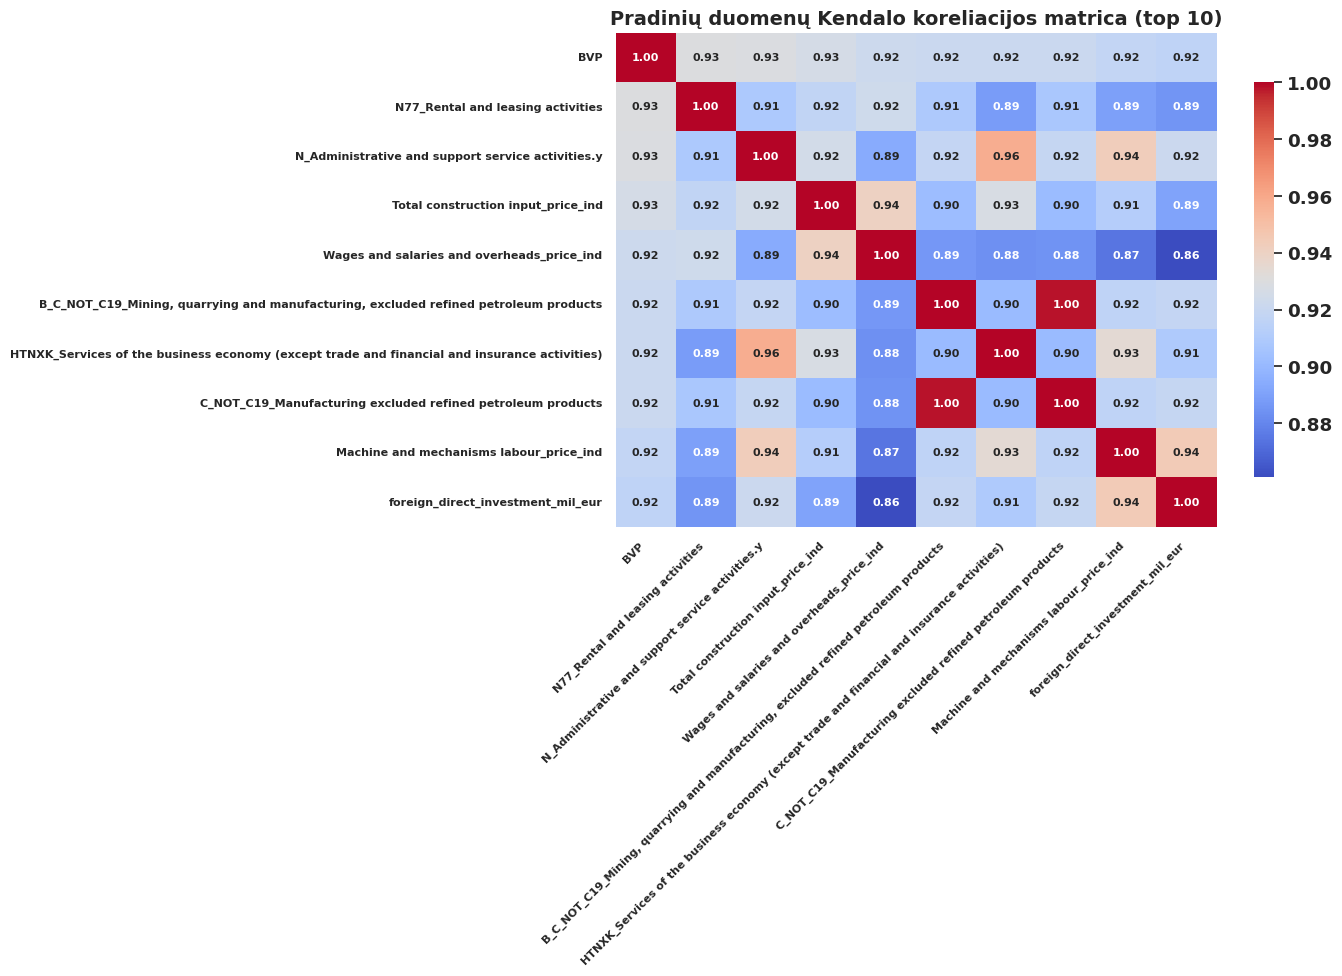

In [65]:
# pradiniai duomenys
# Apskaičiuojame Kendalo koreliacijos matricą
kendall_corr_matrix = df.corr(method='kendall')

# Išrenkame 10 kintamųjų, labiausiai susijusių su BVP (pagal absoliučią koreliaciją)
top_corr_kendall = kendall_corr_matrix["BVP"].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(14, 10))

heatmap = sns.heatmap(
    df[top_corr_kendall].corr(method='kendall'),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 8},
    cbar_kws={'shrink': 0.8}
)

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.title("Pradinių duomenų Kendalo koreliacijos matrica (top 10)", fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig("kendall_top10_heatmap.png", dpi=300)
plt.show()

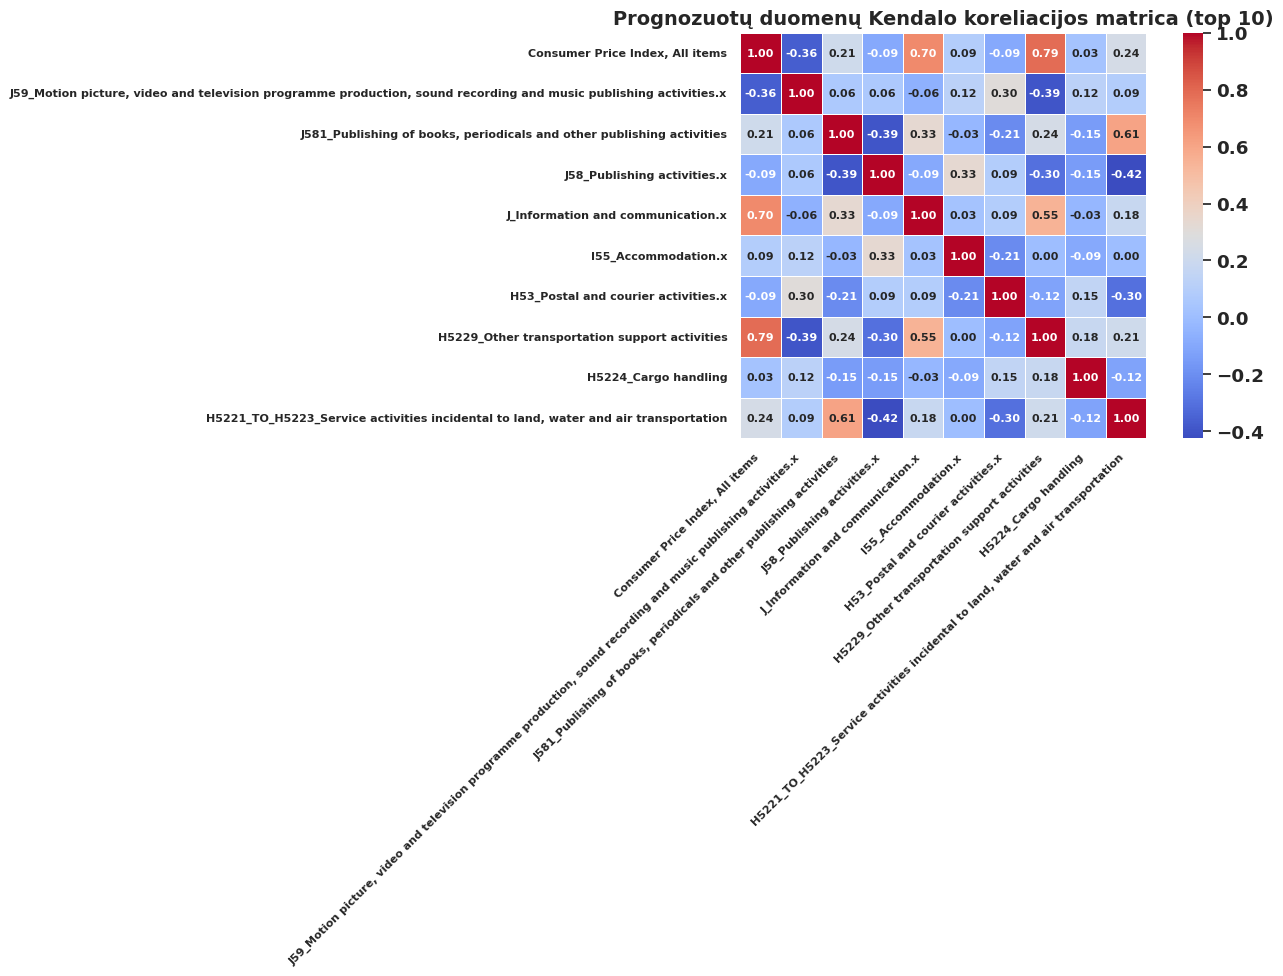

In [66]:
#prognozuoti duomenys

df = forecast_df.copy()
df = df.drop(columns=df.columns[0])

kendall_corr = df.corr(method='kendall')
pairs = (
    kendall_corr.where(~np.tril(np.ones(kendall_corr.shape), -1).astype(bool))
    .stack()
    .reset_index()
)
pairs.columns = ['Variable 1', 'Variable 2', 'Kendall Correlation']
pairs['Abs Correlation'] = pairs['Kendall Correlation'].abs()

top_10_pairs = pairs.sort_values(by='Abs Correlation', ascending=False).head(10)
top_vars = pd.unique(top_10_pairs[['Variable 1', 'Variable 2']].values.ravel())
top_corr_matrix = kendall_corr.loc[top_vars, top_vars]

plt.figure(figsize=(14, 10))
sns.heatmap(
    top_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Prognozuotų duomenų Kendalo koreliacijos matrica (top 10)", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig("kendall_forecast_top10_heatmap.png", dpi=300)
plt.show()

In [67]:
################################################prognozės į priekį####################################################
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="gluonts")

#file_location = "extended_data2.csv"
#file_location = "extended_data3.csv"
file_location = "extended_data4.csv"
df = (
    pd.read_csv(file_location)
    .assign(timestamp=lambda d: pd.to_datetime(d["timestamp"]))
    .set_index("timestamp")
    .sort_index()
)

FREQ = "QS-MAR"
PRED_LEN = 12
history_factor = 5
history_length = history_factor * PRED_LEN

series = [
    {
        FieldName.START: pd.Timestamp(df.index[0], freq=FREQ),
        FieldName.TARGET: df[col].to_numpy(dtype=np.float32),
        FieldName.ITEM_ID: col,
    }
    for col in df.columns
]

#visi duom mokymui, kad galetume iseiti uz ribu
train_entries = []
for entry in series:
    e_train = entry.copy()
    e_train[FieldName.TARGET] = entry[FieldName.TARGET]
    train_entries.append(e_train)

train_ds = MultivariateGrouper()(train_entries)
metadata = MetaData(freq=FREQ, prediction_length=PRED_LEN)

estimator = TACTiSEstimator(
    model_parameters={
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 6,
        "copula_input_encoder_layers": 6,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 4,
        "positional_encoding": {"dropout": 0.1},
        "flow_temporal_encoder": {
            "attention_layers": 6,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.1,
        },
        "copula_temporal_encoder": {
            "attention_layers": 6,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.1,
        },
        "copula_decoder": {
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    },
    num_series=train_ds.list_data[0]["target"].shape[0],
    history_length=history_length,
    prediction_length=PRED_LEN,
    freq=FREQ,
    trainer=TACTISTrainer(
        epochs_phase_1=20,
        epochs_phase_2=20,
        batch_size=32,
        learning_rate=0.001,
        weight_decay=1e-4,
        clip_gradient=1e3,
        device=device,
        checkpoint_dir="checkpoints",
    ),
    cdf_normalization=False,
    num_parallel_samples=300,
)

model = estimator.train(train_ds, validation_data=train_ds, num_workers=1)

estimator.model_parameters["skip_copula"] = False

transformation = estimator.create_transformation()
predictor = estimator.create_predictor(
    transformation=transformation,
    trained_network=model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_length,
)
predictor.batch_size = 24


/tmp/slurm-aran9182-176663/ipykernel_172111/3062303717.py:28: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  FieldName.START: pd.Timestamp(df.index[0], freq=FREQ),


Checkpoints will be saved at checkpoints
Performing a batch size search with 10 iterations.
Initial batch size: 32
Using a batch size of: 32
Start epoch: 0
Total Epochs: 40
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 40
Training.
Total number of training batches: 50
Epoch: 0 Average training loss: 7507657.198519688
Validation.
Total number of validation batches: 2
Epoch: 0 Average validation loss: 23845029.658656843
Epochs since best epoch: 0
Checkpoint of epoch 0 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 0 saved at checkpoints/best_stage_1.pth.tar


Epoch: 1 / 40
Training.
Total number of training batches: 50
Epoch: 1 Average training loss: 245272.48644922292
Validation.
Total number of validation batches: 2
Epoch: 1 Average validation loss: 25.440061049027875
Epochs since best epoch: 0
Checkpoint of epoch 1 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 1 saved at checkpoints/best_stage_1.pth.tar


Epoch: 2 / 40
Training.
Total number o

saved in forecast_outputs/future_forecasts.csv
History freq: None
Forecast freq: <QuarterBegin: startingMonth=3>


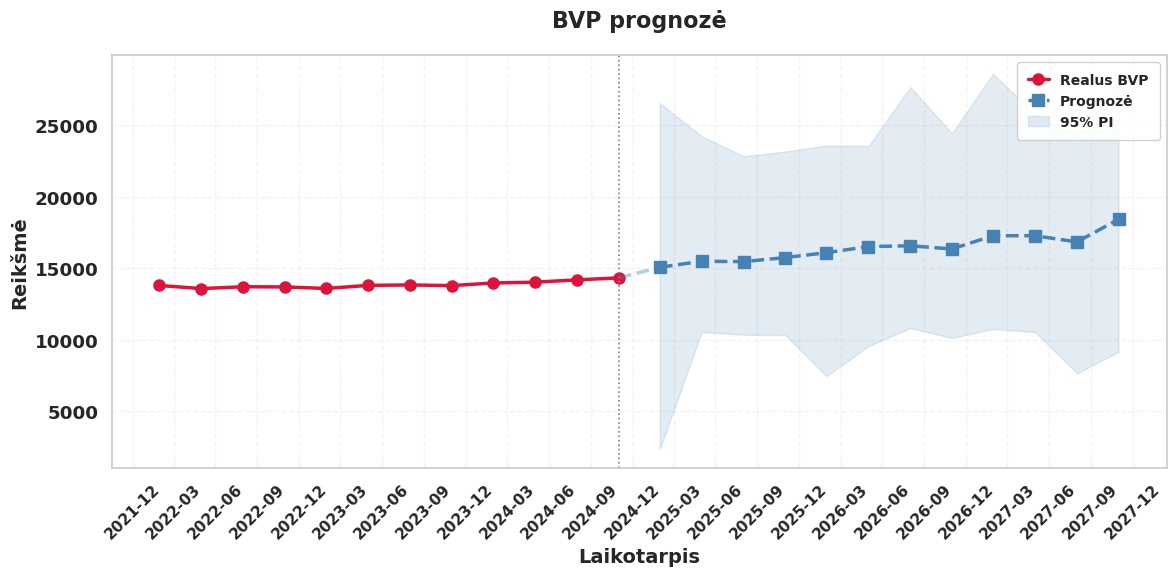

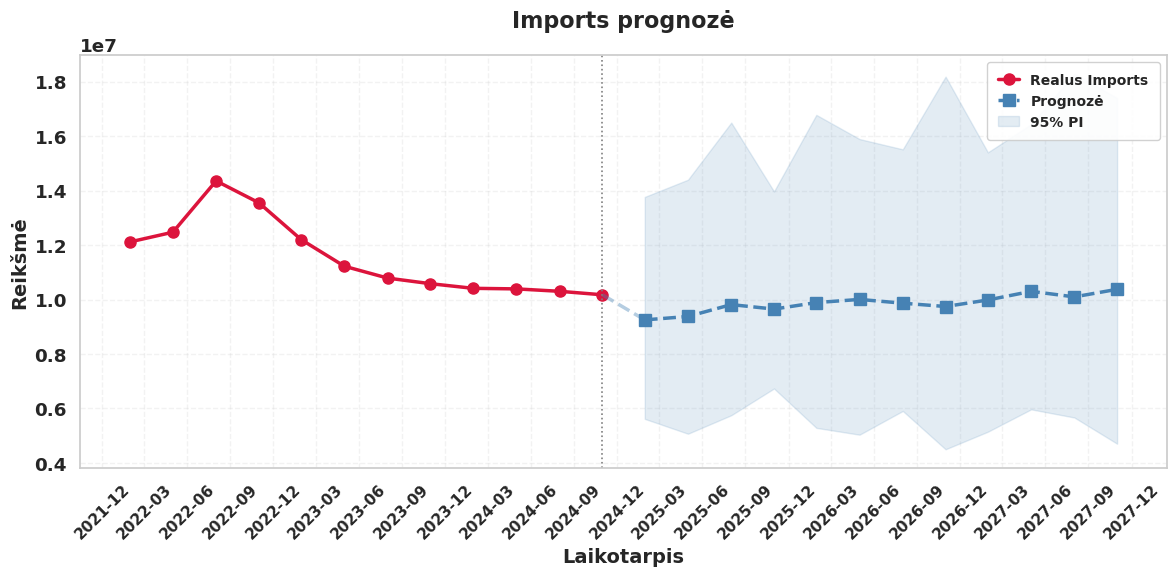

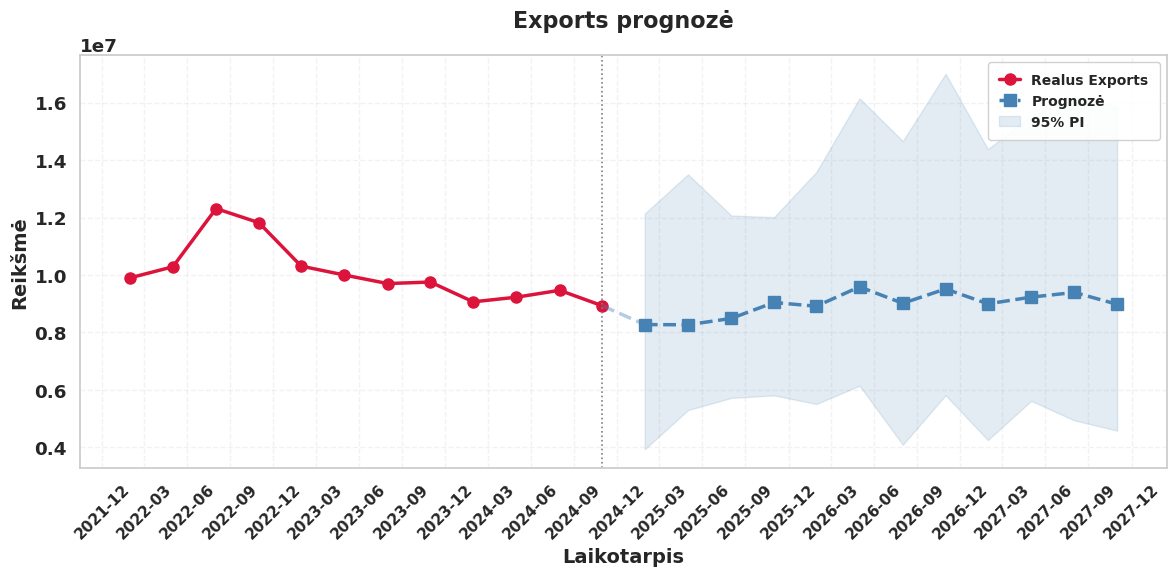

In [68]:
#duomenis prognozavimui i prieki
import seaborn as sns
import matplotlib.dates as mdates
inference_entries = []
for entry in series:
    full_target = entry[FieldName.TARGET]
    start_idx = len(full_target) - history_length

    inf_entry = entry.copy()
    inf_entry[FieldName.START] = (
        entry[FieldName.START] + pd.tseries.frequencies.to_offset(FREQ) * start_idx
    )
    inf_entry[FieldName.TARGET] = full_target[start_idx:]
    inference_entries.append(inf_entry)

inference_ds = MultivariateGrouper()(inference_entries)

#prognoze
forecast_it, ts_it = make_evaluation_predictions(
    dataset=inference_ds,
    predictor=predictor,
    num_samples=100,
)

forecasts = list(forecast_it)
targets = list(ts_it)

#visoms eilutems
series_names = [entry[FieldName.ITEM_ID] for entry in series]
forecast_dates = pd.date_range(
    start=df.index[-1] + pd.offsets.QuarterBegin(startingMonth=3),
    periods=PRED_LEN,
    freq=FREQ
)

#df su progn
forecast_matrix = forecasts[0].quantile(0.5)  # (PRED_LEN, num_series)
forecast_df = pd.DataFrame(
    forecast_matrix,
    columns=series_names,
    index=forecast_dates
)

#csv
output_folder = Path("forecast_outputs")
output_folder.mkdir(exist_ok=True)
forecast_df.to_csv(output_folder / "future_forecasts.csv")
print(f"saved in {output_folder / 'future_forecasts.csv'}")

target_series_list = ["BVP", "Imports", "Exports"]

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

target_series_list = ["BVP", "Imports", "Exports"]

print("History freq:", history.index.freq)
print("Forecast freq:", forecast_dates.freq)

for target_series in target_series_list:
    if target_series in df.columns:
        plt.figure(figsize=(12, 6))
        
        history = df[target_series].iloc[-12:]
        history.index = pd.to_datetime(history.index)
        forecast_values = forecast_df[target_series]
        forecast_values.index = pd.to_datetime(forecast_values.index)
        
        plt.plot(history.index, history, 
                label=f"Realus {target_series}", 
                color="crimson", 
                linewidth=2.5, 
                marker='o',
                markersize=8)
                
        plt.plot(forecast_values.index, forecast_values, 
                label="Prognozė", 
                color="steelblue", 
                linestyle="--", 
                linewidth=2.5, 
                marker='s',
                markersize=8)
        
        if target_series in series_names:
            idx = series_names.index(target_series)
            plt.fill_between(
                forecast_values.index,
                forecasts[0].quantile(0.025)[:, idx],
                forecasts[0].quantile(0.975)[:, idx],
                color="steelblue",
                alpha=0.15,
                label="95% PI"
            )
        
        if len(history) > 0 and len(forecast_values) > 0:
            plt.plot([history.index[-1], forecast_values.index[0]], 
                    [history.iloc[-1], forecast_values.iloc[0]],
                    color="steelblue",
                    linestyle="--",
                    linewidth=2.5,
                    alpha=0.4)
        
        ax = plt.gca()
        plt.margins(x=0.05)
        
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45, fontsize=11)
        
        if len(history) > 0:
            plt.axvline(x=history.index[-1], color="gray", linestyle=":", linewidth=1.2)
        
        plt.legend(loc='upper right', 
                  fontsize=10,
                  frameon=True,
                  framealpha=0.9,
                  borderpad=0.8,
                  handlelength=1.5)
        
        plt.xlabel("Laikotarpis", fontsize=14, fontweight='bold')
        plt.ylabel("Reikšmė", fontsize=14, fontweight='bold')
        plt.title(f"{target_series} prognozė", 
                 fontsize=16, 
                 fontweight='bold',
                 pad=20)
        
        plt.grid(True, linestyle="--", alpha=0.25)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: {target_series} not found in dataframe columns")


In [10]:
# SEED = 123
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
# warnings.filterwarnings("ignore", category=FutureWarning, module="gluonts")

# #file_location = "extended_data2.csv"
# file_location = "extended_data3.csv"
# df = (
#     pd.read_csv(file_location)
#       .assign(timestamp=lambda d: pd.to_datetime(d["timestamp"]))
#       .set_index("timestamp")
#       .sort_index()
# )

# FREQ = "Q"
# PRED_LEN = 12
# history_factor=5
# history_length = history_factor * PRED_LEN


# series = [
#     {
#         FieldName.START : pd.Timestamp(df.index[0], freq=FREQ),  # <-- add freq!
#         FieldName.TARGET: df[col].to_numpy(dtype=np.float32),
#         FieldName.ITEM_ID: col,
#     }
#     for col in df.columns
# ]

# # 80/20 split:

# train_entries, valid_entries = [], []

# for entry in series:                      # one loop per original column
#     target      = entry[FieldName.TARGET]
#     n_total     = len(target)

#     cut_point   = int(0.8 * n_total)      # ---- 80 % cutoff
#     cut_point   = max(cut_point, history_length + 1)  # safety guard

#     # ------------------ training slice (0 ... cut_point-1)
#     e_train = entry.copy()
#     e_train[FieldName.TARGET] = target[:cut_point]
#     train_entries.append(e_train)

#     start_idx   = cut_point - history_length
#     e_valid = entry.copy()
#     e_valid[FieldName.START] = (
#         entry[FieldName.START]
#         + pd.tseries.frequencies.to_offset(FREQ) * start_idx
#     )
#     e_valid[FieldName.TARGET] = target[start_idx:]
#     valid_entries.append(e_valid)


# train_ds = MultivariateGrouper()(train_entries)
# valid_ds = MultivariateGrouper()(valid_entries)
# metadata = MetaData(freq=FREQ, prediction_length=PRED_LEN)

# # Tactis call:



# estimator = TACTiSEstimator(
#     model_parameters = {
#         "flow_series_embedding_dim": 5,
#         "copula_series_embedding_dim": 5,
#         "flow_input_encoder_layers": 2,
#         "copula_input_encoder_layers": 2,
#         "input_encoding_normalization": True,
#         "data_normalization": "standardization",
#         "loss_normalization": "series",
#         "bagging_size": 4,
#         "positional_encoding":{
#             "dropout": 0.0,
#         },
#         "flow_temporal_encoder":{
#             "attention_layers": 2,
#             "attention_heads": 1,
#             "attention_dim": 16,
#             "attention_feedforward_dim": 16,
#             "dropout": 0.0,
#         },
#         "copula_temporal_encoder":{
#             "attention_layers": 2,
#             "attention_heads": 1,
#             "attention_dim": 16,
#             "attention_feedforward_dim": 16,
#             "dropout": 0.0,
#         },
#         "copula_decoder":{
#             "min_u": 0.05,
#             "max_u": 0.95,
#             "attentional_copula": {
#                 "attention_heads": 3,
#                 "attention_layers": 1,
#                 "attention_dim": 8,
#                 "mlp_layers": 2,
#                 "mlp_dim": 48,
#                 "resolution": 20,
#                 "activation_function": "relu"
#             },
#             "dsf_marginal": {
#                 "mlp_layers": 2,
#                 "mlp_dim": 48,
#                 "flow_layers": 2,
#                 "flow_hid_dim": 8,
#             },
#         },
#     },
#     num_series = train_ds.list_data[0]["target"].shape[0],
#     history_length = history_factor * metadata.prediction_length,
#     prediction_length = metadata.prediction_length,
#     freq = metadata.freq,
#     trainer = TACTISTrainer(
#         epochs_phase_1 = 20,
#         epochs_phase_2 = 20,
#         batch_size = 32,
#         #num_batches_per_epoch = 512,
#         learning_rate = 1e-3,
#         weight_decay = 1e-4,
#         #maximum_learning_rate = 1e-3,
#         clip_gradient = 1e3,
#         device = torch.device("cuda:0"),
#         checkpoint_dir = "checkpoints",
#     ),
#     cdf_normalization = False,
#     num_parallel_samples = 300,
# )

# model = estimator.train(train_ds, valid_ds, num_workers=1)

/tmp/slurm-aran9182-175391/ipykernel_1136939/3863263290.py:28: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  FieldName.START : pd.Timestamp(df.index[0], freq=FREQ),  # <-- add freq!


Checkpoints will be saved at checkpoints
Performing a batch size search with 10 iterations.
Initial batch size: 32
Using a batch size of: 32
Start epoch: 0
Total Epochs: 40
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 40
Training.
Total number of training batches: 50
Epoch: 0 Average training loss: 10.39081297960936
Validation.
Total number of validation batches: 1
Epoch: 0 Average validation loss: 0.6739704132080078
Epochs since best epoch: 0
Checkpoint of epoch 0 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 0 saved at checkpoints/best_stage_1.pth.tar


Epoch: 1 / 40
Training.
Total number of training batches: 50
Epoch: 1 Average training loss: -1.6226854809359008
Validation.
Total number of validation batches: 1
Epoch: 1 Average validation loss: -1.132077407836914
Epochs since best epoch: 0
Checkpoint of epoch 1 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 1 saved at checkpoints/best_stage_1.pth.tar


Epoch: 2 / 40
Training.
Total number 

Performing a batch size search with 10 iterations.
Initial batch size: 32
Using a batch size of: 32
Start epoch: 0
Total Epochs: 40
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 40
Training.
Total number of training batches: 50
Epoch: 0 Average training loss: 9.51353994041097
Validation.
Total number of validation batches: 1
Epoch: 0 Average validation loss: 0.2600577354431152
Epochs since best epoch: 0
Checkpoint of epoch 0 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 0 saved at checkpoints/best_stage_1.pth.tar


Epoch: 1 / 40
Training.
Total number of training batches: 50
Epoch: 1 Average training loss: -1.7426604073421628
Validation.
Total number of validation batches: 1
Epoch: 1 Average validation loss: -0.8724061965942382
Epochs since best epoch: 0
Checkpoint of epoch 1 saved at checkpoints/last_stage_1.pth.tar
Checkpoint of epoch 1 saved at checkpoints/best_stage_1.pth.tar


Epoch: 2 / 40
Training.
Total number of training batches: 50
Epoch: 2 Average 

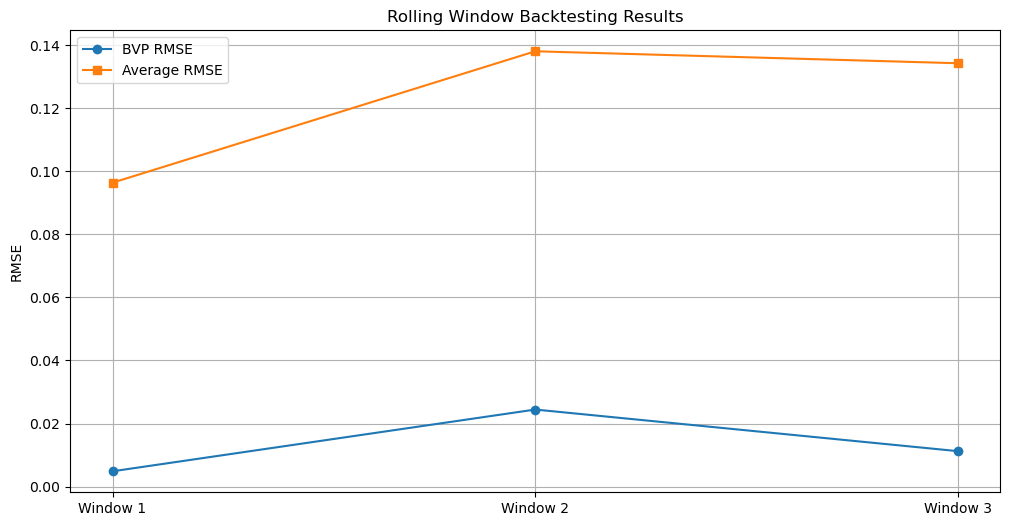

In [41]:

# estimator.model_parameters["skip_copula"] = False

# # ========== Rolling Window Backtesting ==========
# def rolling_window_backtest(full_data, n_windows=4):
#     results = []
#     window_size = len(train_ds.list_data[0]["target"])  # pradinio lango dydis
#     step_size = PRED_LEN  #step
    
#     for i in range(n_windows):
#         # slenkam per step_size
#         start_idx = i * step_size
#         end_idx = start_idx + window_size
#         pred_start = end_idx
        
#         if end_idx + PRED_LEN > len(full_data):
#             break
        
#         print(f"\nWindow {i+1}/{n_windows}: {full_data.index[start_idx].date()} to {full_data.index[end_idx-1].date()}")
        
#         #duomenu paruosimas esamam langui
#         window_entries = []
#         for entry in series:
#             e = entry.copy()
#             e[FieldName.TARGET] = entry[FieldName.TARGET][start_idx:end_idx]
#             window_entries.append(e)
        
#         window_ds = MultivariateGrouper()(window_entries)
        
#         #prognoze
#         forecast_it, ts_it = make_evaluation_predictions(
#             dataset=window_ds,
#             predictor=predictor,
#             num_samples=100
#         )
#         forecasts = list(forecast_it)
#         targets = list(ts_it)
        
#         #metrikos
#         actuals = full_data.iloc[pred_start:pred_start+PRED_LEN]
#         preds = forecasts[0].mean.T  # (num_series, pred_len)
        
#         #RMSE
#         rmse = {}
#         for j, col in enumerate(full_data.columns):
#             rmse[col] = np.sqrt(mean_squared_error(
#                 actuals[col].values, 
#                 preds[j]
#             ))
        
#         results.append({
#             "window": i,
#             "start_date": full_data.index[start_idx],
#             "end_date": full_data.index[end_idx-1],
#             "rmse": rmse,
#             "avg_rmse": np.mean(list(rmse.values()))
#         })
    
#     return pd.DataFrame(results)

# #backtesting
# backtest_results = rolling_window_backtest(df, n_windows=4)
# print(backtest_results)


# #rezultatai
# print("\n=== Backtesting Results ===")
# print(f"Average RMSE across all windows: {backtest_results['avg_rmse'].mean():.4f}")

# # BVP grafikas
# plt.figure(figsize=(12, 6))
# plt.plot(backtest_results.index, backtest_results['rmse'].apply(lambda x: x['BVP']), 
#          marker='o', label='BVP RMSE')
# plt.plot(backtest_results.index, backtest_results['avg_rmse'], 
#          marker='s', label='Average RMSE')
# plt.xticks(backtest_results.index, [f"Window {i+1}" for i in backtest_results.index])
# plt.title("Rolling Window Backtesting Results")
# plt.ylabel("RMSE")
# plt.grid(True)
# plt.legend()
# plt.show()


In [33]:
%pip uninstall numpy -y
%pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
print(np.__version__)

1.23.5


In [27]:
#################################################rolling window backtesting#######################################################################
import numpy as np
import pandas as pd
import torch
import random
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset, MetaData
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import make_evaluation_predictions
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.trainer import TACTISTrainer
from pathlib import Path

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="gluonts")

file_location = "extended_data2.csv"
#file_location = "extended_data3.csv"
#file_location = "extended_data4.csv"
df = (
    pd.read_csv(file_location)
    .assign(timestamp=lambda d: pd.to_datetime(d["timestamp"]))
    .set_index("timestamp")
    .sort_index()
)

df.index = df.index.to_period(FREQ).to_timestamp()
print(df.index)
print(df.index.freq)
FREQ = "Q"
PRED_LEN = 12
history_factor = 5
history_length = history_factor * PRED_LEN

series = [
    {
        FieldName.START: df.index[0],
        FieldName.TARGET: df[col].to_numpy(dtype=np.float32),
        FieldName.ITEM_ID: col,
    }
    for col in df.columns
]

train_entries, valid_entries = [], []

for entry in series:
    target = entry[FieldName.TARGET]
    n_total = len(target)
    cut_point = int(0.8 * n_total)
    cut_point = max(cut_point, history_length + 1)

    e_train = entry.copy()
    e_train[FieldName.TARGET] = target[:cut_point]
    train_entries.append(e_train)

    start_idx = cut_point - history_length
    e_valid = entry.copy()
    e_valid[FieldName.START] = (
        entry[FieldName.START]
        + pd.tseries.frequencies.to_offset(FREQ) * start_idx
    )
    e_valid[FieldName.TARGET] = target[start_idx:]
    valid_entries.append(e_valid)

train_ds = MultivariateGrouper()(train_entries)
valid_ds = MultivariateGrouper()(valid_entries)
metadata = MetaData(freq=FREQ, prediction_length=PRED_LEN)

def rolling_window_backtest(full_data, predictor, n_windows=4):
    results = []
    window_size = len(train_ds.list_data[0]["target"]) 
    step_size = PRED_LEN
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        pred_start = end_idx
        
        if end_idx + PRED_LEN > len(full_data):
            break
        
        print(f"\nWindow {i+1}/{n_windows}: {full_data.index[start_idx].date()} to {full_data.index[end_idx-1].date()}")
        
        window_entries = []
        for entry in series:
            e = entry.copy()
            e[FieldName.TARGET] = entry[FieldName.TARGET][start_idx:end_idx]
            e[FieldName.START] = entry[FieldName.START] + pd.tseries.frequencies.to_offset(FREQ) * start_idx
            window_entries.append(e)
        
        window_ds = MultivariateGrouper()(window_entries)
        
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=window_ds,
            predictor=predictor,
            num_samples=100
        )
        
        forecasts = list(forecast_it)
        targets = list(ts_it)
        
        actuals = full_data.iloc[pred_start:pred_start+PRED_LEN]
        preds = forecasts[0].mean.T  # (num_series, pred_len)
        
        rmse = {
            col: np.sqrt(mean_squared_error(actuals[col].values, preds[j]))
            for j, col in enumerate(full_data.columns)
        }
        
        results.append({
            "window": i,
            "start_date": full_data.index[start_idx],
            "end_date": full_data.index[end_idx-1],
            "rmse": rmse,
            "avg_rmse": np.mean(list(rmse.values()))
        })
    
    return pd.DataFrame(results)

param_grid = [
    {
        "dropout": 0.0,
        "epochs_phase_1": 10,
        "epochs_phase_2": 10,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "num_layers": 2,
    },
    {
        "dropout": 0.0,
        "epochs_phase_1": 30,
        "epochs_phase_2": 30,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "num_layers": 2,
    },
    {
        "dropout": 0.0,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "num_layers": 3,
    },
    {
        "dropout": 0.0,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "num_layers": 4,
    },
    {
        "dropout": 0.0,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 0.005,
        "num_layers": 3,
    },
    {
        "dropout": 0.2,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 0.01,
        "num_layers": 4,
    },
    {
        "dropout": 0.1,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "num_layers": 6,
    },
    {
        "dropout": 0.1,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 0.005,
        "num_layers": 5,
    },
    {
        "dropout": 0.1,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "num_layers": 6,
    },

    {
        "dropout": 0.15,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "num_layers": 6,
    },

    {
        "dropout": 0.1,
        "epochs_phase_1": 20,
        "epochs_phase_2": 20,
        "batch_size": 16,
        "learning_rate": 1e-3,
        "num_layers": 6,
    },

    {
        "dropout": 0.15,
        "epochs_phase_1": 40,
        "epochs_phase_2": 40,
        "batch_size": 128,
        "learning_rate": 0.0005,
        "num_layers": 6,
    },

    
]

all_results = []


for i, params in enumerate(param_grid):
    print(f"\n=== Grid {i+1}/{len(param_grid)}: {params} ===")
    
    estimator = TACTiSEstimator(
        model_parameters={
            "flow_series_embedding_dim": 5,
            "copula_series_embedding_dim": 5,
            "flow_input_encoder_layers": params["num_layers"],
            "copula_input_encoder_layers": params["num_layers"],
            "input_encoding_normalization": True,
            "data_normalization": "standardization",
            "loss_normalization": "series",
            "bagging_size": 4,
            "positional_encoding": {
                "dropout": params["dropout"],
            },
            "flow_temporal_encoder": {
                "attention_layers": params["num_layers"],
                "attention_heads": 1,
                "attention_dim": 16,
                "attention_feedforward_dim": 16,
                "dropout": params["dropout"],
            },
            "copula_temporal_encoder": {
                "attention_layers": params["num_layers"],
                "attention_heads": 1,
                "attention_dim": 16,
                "attention_feedforward_dim": 16,
                "dropout": params["dropout"],
            },
            "copula_decoder": {
                "min_u": 0.05,
                "max_u": 0.95,
                "attentional_copula": {
                    "attention_heads": 3,
                    "attention_layers": 1,
                    "attention_dim": 8,
                    "mlp_layers": 2,
                    "mlp_dim": 48,
                    "resolution": 20,
                    "activation_function": "relu",
                },
                "dsf_marginal": {
                    "mlp_layers": 2,
                    "mlp_dim": 48,
                    "flow_layers": 2,
                    "flow_hid_dim": 8,
                },
            },
            "skip_copula": False,
        },
        num_series=train_ds.list_data[0]["target"].shape[0],
        history_length=history_length,
        prediction_length=PRED_LEN,
        freq=FREQ,
        trainer=TACTISTrainer(
            epochs_phase_1=params["epochs_phase_1"],
            epochs_phase_2=params["epochs_phase_2"],
            batch_size=params["batch_size"],
            learning_rate=params["learning_rate"],
            weight_decay=1e-4,
            clip_gradient=1e3,
            device=device,
            checkpoint_dir="checkpoints",
        ),
        cdf_normalization=False,
        num_parallel_samples=300,
    )
    
    model = estimator.train(train_ds, valid_ds, num_workers=1)
    
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(
        transformation=transformation,
        trained_network=model,
        device=device,
        experiment_mode="forecasting",
        history_length=history_length,
    )
    predictor.batch_size = 32
    
    # Backtesting
    backtest_results = rolling_window_backtest(df, predictor, n_windows=4)
    print(backtest_results)
    
    avg_rmse = backtest_results['avg_rmse'].mean()
    print(f"Average RMSE across all windows: {avg_rmse:.4f}")
    
    #rezultatai
    result = {
        "params": params,
        "backtest_results": backtest_results,
        "avg_rmse": avg_rmse,
    }
    all_results.append(result)
    
    #grafikai
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_results.index, backtest_results['rmse'].apply(lambda x: x[df.columns[0]]), 
             marker='o', label=f'{df.columns[0]} RMSE')
    plt.plot(backtest_results.index, backtest_results['avg_rmse'], 
             marker='s', label='Average RMSE')
    plt.xticks(backtest_results.index, [f"Window {i+1}" for i in backtest_results.index])
    plt.title(f"Model Results (Params: {params})")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()

#bendra info
print("\n=== Grid Search Results ===")
for result in all_results:
    print(f"\nParameters: {result['params']}")
    print(f"Average RMSE: {result['avg_rmse']:.4f}")

#palyginimas modelių
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", len(all_results))

for i, (result, color) in enumerate(zip(all_results, colors)):
    plt.plot(
        result['backtest_results']['avg_rmse'],
        marker='o', linestyle='--', color=color,
        label=f"Model {i+1} (Avg RMSE: {result['avg_rmse']:.4f})", linewidth=2
    )

plt.xticks(
    range(len(all_results[0]['backtest_results'])),
    [f"Window {i+1}" for i in range(len(all_results[0]['backtest_results']))]
)
plt.title("Comparison of Models Across Backtest Windows", fontsize=14)
plt.xlabel("Window", fontsize=12)
plt.ylabel("Average RMSE", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#geriausias modelis
best_result = min(all_results, key=lambda x: x['avg_rmse'])
print(f"\nBest model parameters: {best_result['params']}")
print(f"Best model average RMSE: {best_result['avg_rmse']:.4f}")

DatetimeIndex(['1999-07-01', '1999-10-01', '2000-01-01', '2000-04-01',
               '2000-07-01', '2000-10-01', '2001-01-01', '2001-04-01',
               '2001-07-01', '2001-10-01',
               ...
               '2022-07-01', '2022-10-01', '2023-01-01', '2023-04-01',
               '2023-07-01', '2023-10-01', '2024-01-01', '2024-04-01',
               '2024-07-01', '2024-10-01'],
              dtype='datetime64[ns]', name='timestamp', length=102, freq='QS-OCT')
<QuarterBegin: startingMonth=10>

=== Grid 1/12: {'dropout': 0.0, 'epochs_phase_1': 10, 'epochs_phase_2': 10, 'batch_size': 32, 'learning_rate': 0.001, 'num_layers': 2} ===
Checkpoints will be saved at checkpoints
Performing a batch size search with 10 iterations.
Initial batch size: 32
Using a batch size of: 32
Start epoch: 0
Total Epochs: 20
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 20
Training.
Total number of training batches: 50


KeyboardInterrupt: 